# Open Neuromorphic Seminar - Hands-On with snnTorch
## By Jason K. Eshraghian (www.ncg.ucsc.edu)


[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="200">](https://github.com/jeshraghian/snntorch/)

In [14]:
# !pip install snntorch 
# # shift + enter

In [15]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def dvs_animator(spike_data):
  fig, ax = plt.subplots()
  anim = splt.animator((spike_data[:,0] + spike_data[:,1]), fig, ax)
  return anim


*What will I learn?*

**The Basics:**
1. The leaky integrate-and-fire (`snn.Leaky`) neuron in 5 mins
2. Train an SNN classifier using surrogate gradient descent

**The Fancier Stuff**
3. Population Codes
4. Recurrent SNNs and Spiking LSTMs
5. Learning precise spike-timing
6. Hardware Friendly Training
  - Weight Quantization with Brevitas
  - State Quantization

*If there's time...*
7. SNNs can sometimes be a pain in the ass to train. Hyperparameter Optimization with Optuna.

# 1. The Leaky Integrate-and-Fire Neuron
### (...in 20 mins)



In [16]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
import torch

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML

In [17]:
lif = snn.Leaky(beta=0.8) # LIF neuron with a decay rate of 0.8
# Decay rate of the neuron's membrane potential

In [18]:
# setup inputs
num_steps = 200

x = torch.cat((torch.zeros(10), torch.ones(20)*0.3, torch.zeros(170)))

mem = torch.zeros(1)

spk = torch.zeros(1)

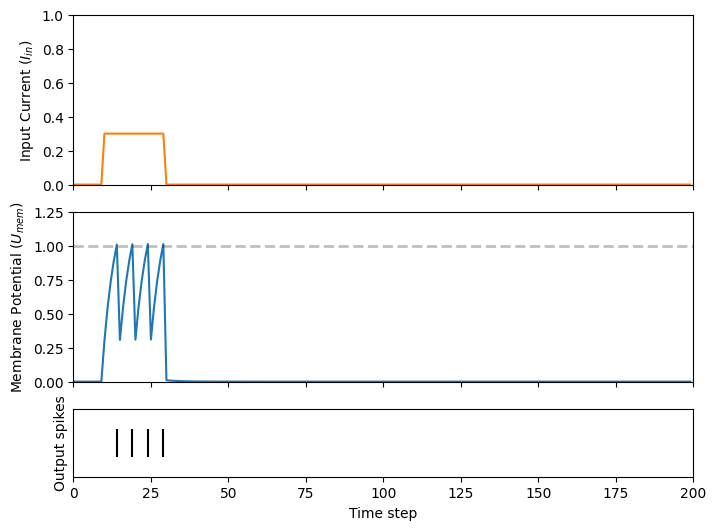

In [19]:
mem_rec = []
spk_rec = []

for step in range(num_steps):
  spk, mem = lif(x[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)


# convert lists to tensors
# to accelerate tensors(higher order matrixes)
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x, mem_rec, spk_rec, thr_line=1, ylim_max1=1.0)

# 2. Train an SNN Classifier 
### (...in 10-ish mins)

In [20]:
# import
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools

### Boilerplate: DataLoading the MNIST Dataset

In [21]:
# dataloader arguments
batch_size = 128
data_path='./data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
## if you're on M1 or M2 GPU:
# device = torch.device("mps")

In [22]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)


In [23]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## Construct a Fully Connected SNN

In [24]:
# Network Architecture
num_inputs = 28 * 28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [25]:
from snntorch import surrogate

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=1)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer (2nd spiking activation, output spikes)
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
          cur1 = self.fc1(x.flatten(1)) #batch 128 x 784
          spk1, mem1 = self.lif1(cur1, mem1)
          
          cur2 = self.fc2(x.flatten(1))
          spk2, mem2 = self.lif2(cur2, mem2)            
          
          #store in list 
          spk2_rec.append(spk2)
          mem2_rec.append(mem2)
        
        return torch.stack(spk)
# Load the network onto CUDA if available
net = Net().to(device)

## Training the SNN

In [26]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

num_epochs = 1 # 60000 / 128 = 468
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.sum(0), targets) # batch x num_out

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x784 and 1000x10)

In [ ]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [ ]:
print(f"Test set accuracy: {measure_accuracy(net, test_loader)}")

## Convolutional SNN Classifier

In [ ]:
# Define Network
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 8, 5, padding="same")
        self.lif1 = snn.Leaky(beta=beta)
        self.mp1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(8, 24, 5, padding="same")
        self.lif2 = snn.Leaky(beta=beta)
        self.mp2 = nn.MaxPool2d(2)

        self.fc = nn.Linear(24 * 7 * 7, 10)
        self.lif3 = snn.Leaky(beta=beta)


    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        # time-loop
        for step in range(num_steps):
            cur1 = self.conv1(x)
            spk1, mem1 = self.lif1(self.mp1(cur1), mem1)
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(self.mp2(cur2), mem2)
            cur3 = self.fc(spk2.flatten(1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
        
# Load the network onto CUDA if available
convnet = ConvNet().to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=1e-2, betas=(0.9, 0.999))

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        convnet.train()
        spk_rec, _ = convnet(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break

In [ ]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()

print(f"ConvNet Accuracy: {measure_accuracy(convnet, test_loader)}")

<img src='https://i.ytimg.com/vi/Rt8LTxysC2s/maxresdefault.jpg' width="400">

# 3. Population Codes


In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_steps = 1
        num_outputs = 10
        population = 100

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs*population)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

        
# Load the network onto CUDA if available
popnet = Net().to(device)

In [ ]:
from snntorch import functional as SF

In [ ]:
loss_fn = SF.ce_count_loss(population_code=True, num_classes=10)
optimizer = torch.optim.Adam(popnet.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        popnet.train()
        spk_rec, _ = popnet(data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break

In [ ]:
def population_acc(testloader, model):
  with torch.no_grad():
    model.eval()
    running_accuracy = 0
    running_length = 0
    for data, labels in iter(testloader):
      data = data.to(device)
      labels = labels.to(device)

      # calculate accuracy below
      spk_rec, _ = model(data)
      running_accuracy += SF.accuracy_rate(spk_rec, labels, population_code=True, num_classes=10)
      running_length += len(labels)
    
    accuracy = running_accuracy * 100 / running_length
    
    return accuracy 

In [ ]:
accuracy = population_acc(test_loader, popnet)
print(f"Population Code Accuracy: {accuracy}%")

# 4. Recurrent SNNs and Spiking LSTMs
## 4.1 Neuromorphic DataLoading with Tonic

[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="150">](https://github.com/neuromorphs/tonic/)

In [ ]:
!pip install tonic --quiet 

In [ ]:
import tonic

dataset = tonic.datasets.POKERDVS(save_to='./data', train=True)
testset = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, target = dataset[0]
print(events)
tonic.utils.plot_event_grid(events)

In [ ]:
tonic.datasets.POKERDVS.sensor_size

In [ ]:
import torchvision
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader

# time_window
frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000), 
                                    tonic.transforms.ToFrame(
                                        sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                        time_window=1000)
                                     ])

batch_size = 8
cached_trainset = DiskCachedDataset(dataset, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(testset, transform=frame_transform, cache_path='./cache/pokerdvs/test')

trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

In [ ]:
for data, labels in iter(trainloader):
  print(data.size())
  print(labels)
  break

In [ ]:
animation = dvs_animator(data[:, 1])
HTML(animation.to_html5_video())

## 4.2 Recurrent SNN

In [ ]:
# Define Network
class RSNN(nn.Module):
    def __init__(self):
        super().__init__()

        # hyperparam stuff
        num_inputs = 35 * 35 * 2
        num_hidden = 512
        num_outputs = 4
        beta = 0.9

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta=beta, linear_features=num_hidden)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.RLeaky(beta=beta, linear_features=num_outputs)

    def forward(self, x):

        # Initialize hidden states at t=0
        spk1, mem1 = self.lif1.init_rleaky()
        spk2, mem2 = self.lif2.init_rleaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(x.size(0)):  # time x batch x num_inputs
            cur1 = self.fc1(x[step].flatten(1))
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, spk2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

        
# Load the network onto CUDA if available
rnet = RSNN().to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnet.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Minibatch training loop
    for data, targets in iter(trainloader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        rnet.train()
        spk_rec, _ = rnet(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break

In [ ]:
print(f"RNet Accuracy: {measure_accuracy(rnet, testloader)}")

## 4.3 Spiking Convolutional LSTM Unit (SCLU)

In [ ]:
# Define Network
class SCLU(nn.Module):
    def __init__(self):
        super().__init__()

        num_outputs = 4
        beta = 0.9

        # Initialize layers
        self.sclu1 = snn.SConv2dLSTM(2, 8, 5, max_pool=2, threshold=0.1)
        self.sclu2 = snn.SConv2dLSTM(8, 16, 5, max_pool=2, threshold=0.1)
        self.fc = nn.Linear(8*8*16, 4)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        syn1, mem1 = self.sclu1.init_sconv2dlstm()
        syn2, mem2 = self.sclu2.init_sconv2dlstm()
        mem3 = self.lif.init_leaky()
        
        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(x.size(0)):
            spk1, syn1, mem1 = self.sclu1(x[step], syn1, mem1)
            spk2, syn2, mem2 = self.sclu2(spk1, syn2, mem2)
            cur2 = self.fc(spk2.flatten(1))
            spk3, mem3 = self.lif(cur2, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

        
# Load the network onto CUDA if available
sclu = SCLU().to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sclu.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Minibatch training loop
    for data, targets in iter(trainloader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        sclu.train()
        spk_rec, _ = sclu(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break

In [ ]:
print(f"SCLU Accuracy: {measure_accuracy(sclu, testloader)}")

In [ ]:
spk_rec.size()

In [ ]:
print(targets[0])
spk_rec[:, 0]

# 5. Precise Spike-Timing

We're still figuring this bit out!

In [ ]:
net = Net().to(device)

In [ ]:
# spike-timing loss??? 
loss = SF.ce_temporal_loss(on_target=5, off_target=20)


optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 100
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Minibatch training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        sclu.train()
        spk_rec, _ = sclu(data)

        # initialize the loss & sum over time
        # loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        # if counter == 100:
        #   break

In [ ]:
def temporal_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)

      # total accuracy
      running_length += len(targets)
      running_accuracy += SF.accuracy_temporal(spk_rec, targets)

    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [ ]:
print(f"SCLU Accuracy: {temporal_accuracy(sclu, testloader)}")

# 6. Hardware Friendly Training
## 6.1 Weight Quantization

In [ ]:
!pip install brevitas --quiet

In [ ]:
import brevitas.nn as qnn
from snntorch.functional import quant

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        qlif = quant.state_quant(num_bits=8, uniform=False, thr_centered=True)

        # Initialize layers
        self.fc1 = qnn.QuantLinear(num_inputs, num_hidden, weight_bit_width=8, bias=False)
        self.lif1 = snn.Leaky(beta=beta, state_quant=qlif)
        self.fc2 = qnn.QuantLinear(num_hidden, num_outputs, weight_bit_width=8, bias=False)
        self.lif2 = snn.Leaky(beta=beta, state_quant=qlif)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

## 6.2 State Quantization

In [ ]:
from snntorch.functional import quant

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()


        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

# 7. Hyperparameter Optimization with Optuna

In [ ]:
!pip install optuna --quiet
!pip install optuna-dashboard

In [ ]:
# imports
import optuna
import joblib

In [ ]:
def sample_parameters(trial):
    """Initialize randomly sampled parameters."""

    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    lr = trial.suggest_float('lr', 5e-5, 1e-2, log=True)
    dropout_1 = trial.suggest_float('dropout_1', 0, 1)
    dropout_2 = trial.suggest_float('dropout_2', 0, 1)
    beta_1 = trial.suggest_float('beta_1', 0, 1)
    beta_2 = trial.suggest_float('beta_2', 0, 1)
    threshold_1 = trial.suggest_float('threshold_1', 1e-3, 1, log=True)
    threshold_2 = trial.suggest_float('threshold_2', 1e-3, 1, log=True)

    return (batch_size, lr, dropout_1, dropout_2, beta_1, beta_2, threshold_1, threshold_2)

In [ ]:
# parameters to optimize

def config(trial):
    params = sample_parameters(trial)
    batch_size, lr, dropout_1, dropout_2, beta_1, beta_2, threshold_1, threshold_2 = params


    config = {
        'batch_size' : batch_size,
        'lr' : lr,
        'dropout_1' : dropout_1,
        'dropout_2' : dropout_2,
        'beta_1' : beta_1,
        'beta_2' : beta_2,
        'threshold_1' : threshold_1,
        'threshold_2' : threshold_2
    }

    measure_accuracy(convnet, test_loader)}"


In [ ]:
def objective(trial):

    # Training loop - optimize for test-acc

    return test_acc

In [ ]:
n_trials = 5
study_name = "optuna_test"


pruner = optuna.pruners.SuccessiveHalvingPruner()
sampler = optuna.samplers.TPESampler()
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, sampler=sampler, direction='maximize', pruner=pruner, storage=storage_name, load_if_exists=True)
study.optimize(objective, n_trials=n_trials)

# Create a dataframe from the study.
df = study.trials_dataframe()

print(f"Best config: {study.best_params}")
joblib.dump(study, 'optuna.pkl')

## Interested in Becoming a Contributor?

Random Ideas:

* Neurons with adaptive thresholds

* Different types of neurons, e.g., Legendre Memory Units

* Write up tutorials! From integrating new learning rules, combining snnTorch with liquid state machines, or a spiking version of the forward-forward algorithm?

* Dendritic Computation. Integration with Dendrify?

## Current Opportunities for Neuromorphs:

* Telluride 2023 Applications are open! Call for applications [here](https://sites.google.com/view/telluride-2023/home?authuser=0).
* Submit your work to [APL Machine Learning](https://aip.scitation.org/journal/aml)
* Submit your work to the Special Issue on Linking Neuro-AI with Neuromorphic Computing to the [IEEE Journal on Emerging Topics in Circuits and Systems](https://ieee-cas.org/files/ieeecass/2023-02/JETCAS_CFP_23-Q4-r2.pdf)

* ISCAS 2023 Tutorial: [How to Build Open-Source Neuromorphic Hardware and Algorithms](https://iscas2023.org/tutorials) by Jason Eshraghian & Charlotte Frenkel
